In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
import os

import torch

import sparse

import numpy as np

import tqdm.autonotebook as tqdm

import matplotlib.pyplot as plt

from utils import segmentate_patient, resample, CTDataset, plot_3d, subplots_3d

In [5]:
test_patients = sorted(os.listdir('./data/test/'))
train_patients = sorted(os.listdir('./data/train/'))

In [6]:
# mode = 'train'
# PROCESSED_PATH = './processed_data/'

# for patient_n in tqdm.tqdm(range(len(train_patients) if mode == 'train' else len(test_patients))):
#     patient = train_patients[patient_n] if mode == 'train' else test_patients[patient_n]
    
#     all_images, _, _, all_masks, meta_data = segmentate_patient(mode, patient_n)
#     SliceThickness, PixelSpacing = meta_data['SliceThickness'][0], meta_data['PixelSpacing'][0]
#     assert len(PixelSpacing) == 2
    
#     new_spacing = np.array([SliceThickness] + list(PixelSpacing))
#     # noinspection PyBroadException
#     try:
#         ordering, case = np.argsort([float(_) for _ in meta_data['SliceLocation']]), 0
#     except Exception:
#         # noinspection PyBroadException
#         try:
#             ordering, case = np.argsort([float(_) for _ in meta_data['InstanceNumber']]), 1
#         except Exception:
#             ordering, case = np.arange(len(all_images)), 2
    
#     all_images, all_masks = np.array(all_images)[ordering], np.array(all_masks)[ordering]
#     for key, values in meta_data.items():
#         meta_data[key] = np.array(values)[ordering].tolist()
    
#     if len(all_images) != 196:
#         all_images, _ = resample(
#             all_images, [196, *all_images.shape[1:]], SliceThickness, PixelSpacing
#         )
#         all_masks, new_spacing = resample(
#             all_masks, [196, *all_images.shape[1:]], SliceThickness, PixelSpacing
#         )
#         all_masks = all_masks > 0

#         meta_data['SliceThickness'] = [new_spacing[0] for _ in meta_data['SliceThickness']]
#         meta_data['PixelSpacing'] = [[new_spacing[0], new_spacing[1]] for _ in meta_data['PixelSpacing']]

#     base_path = os.path.join(PROCESSED_PATH, mode, train_patients[patient_n])
#     os.makedirs(base_path, exist_ok=True)
    
#     if all_images.shape[1] == 512:
#         all_masks = all_masks[:, ::2, ::2]
#         all_images = all_images[:, ::2, ::2]
#         meta_data['PixelSpacing'] = [[new_spacing[0] * 2, new_spacing[1] * 2] for _ in meta_data['PixelSpacing']] 
#     if all_images.shape[1] == 632:
#         all_masks = all_masks[:, 60:-60:2, 60:-60:2]
#         all_images = all_images[:, 60:-60:2, 60:-60:2]
#         meta_data['PixelSpacing'] = [[new_spacing[0] * 2, new_spacing[1] * 2] for _ in meta_data['PixelSpacing']]
#     if all_images.shape[1] == 768:
#         all_masks = all_masks[:, ::3, ::3]
#         all_images = all_images[:, ::3, ::3]
#         meta_data['PixelSpacing'] = [[new_spacing[0] * 3, new_spacing[1] * 3] for _ in meta_data['PixelSpacing']]
#     if all_images.shape[1] == 1302:
#         all_masks = all_masks[:, 11:-11:5, 11:-11:5]
#         all_images = all_images[:, 11:-11:5, 11:-11:5]
#         meta_data['PixelSpacing'] = [[new_spacing[0] * 5, new_spacing[1] * 5] for _ in meta_data['PixelSpacing']]

#     np.save(os.path.join(base_path, 'meta.npy'), meta_data)
#     np.save(os.path.join(base_path, 'images.npy'), all_images)
#     sparse.save_npz(os.path.join(base_path, 'masks.npz'), sparse.COO(np.array(all_masks)))

In [67]:
import torchvision

import torchio
import torchio.transforms

In [94]:
transforms = torchio.transforms.Compose([
    torchio.transforms.RandomAffine(
        degrees=(10, 10),
        translation=(-10, -10),
        isotropic=False,
        default_pad_value='minimum',
        image_interpolation='linear',
    ),
    torchio.transforms.RandomElasticDeformation(
        max_displacement=3.0
    )
])

In [104]:
# dataset_test = CTDataset(
#     './processed_data/train', 
#     './processed_data/train.csv', 
#     train=False, test_size=0.25, random_state=42
# )
dataset_train = CTDataset(
    './processed_data/train', 
    './processed_data/train.csv', 
    train=True, transform=transforms,
    test_size=0, random_state=42,
    padding_mode=None, padding_constant=None
)

In [105]:
obj = dataset_train[0]
obj_transf = dataset_train[0]

In [118]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# dataset_train = MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dl = DataLoader(dataset_train, batch_size=1, num_workers=1)

In [119]:
for obj in dl:
    print(obj)
    break

PicklingError: Can't pickle <class 'utils.CTDataset'>: it's not the same object as utils.CTDataset

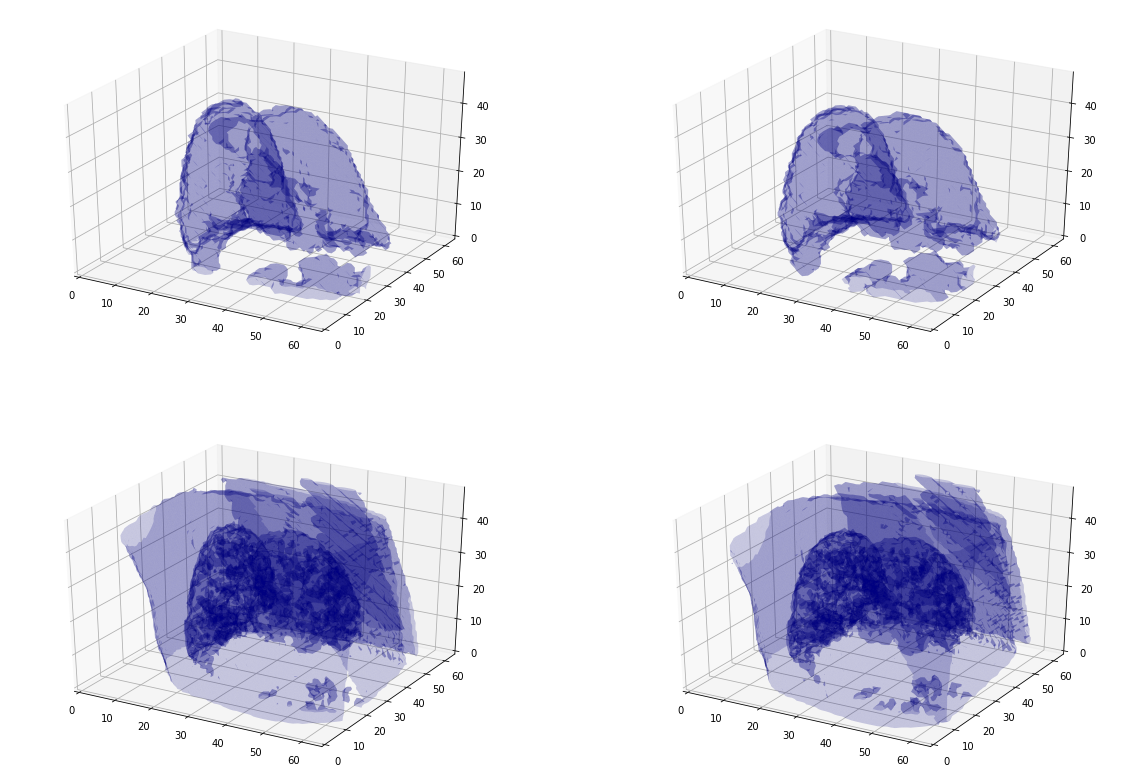

In [106]:
fig, axes = subplots_3d(2, 2, figsize=(20, 14))
plot_3d(axes[0][0], obj.masks.numpy()[0], 4, threshold=0.0)
plot_3d(axes[0][1], obj_transf.masks.numpy()[0], 4, threshold=0.0)

plot_3d(axes[1][0], obj.images.numpy()[0], 4, threshold=-700.0)
plot_3d(axes[1][1], obj_transf.images.numpy()[0], 4, threshold=-700.0)

plt.show()